In [31]:
import pandas as pd 
import nltk
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords 
import gensim 
from gensim.models import Word2Vec
import ssl
import datetime
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
 
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/jshen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jshen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_json("tweets.json")

## Format Data
We want to visualize social media patterns as a timescale, so lets segment the data into bins that can be selected on.

In [4]:
# Add Time Columns
df['year'] = df.apply(lambda x: x["timestamp"].year, axis = 1)
df['month'] = df.apply(lambda x: x["timestamp"].month, axis = 1)

## Perform Word Analysis, by Time Frame 
Using word2vec to analyze word distances amongst the sample tweets, broken down by time frame.

In [23]:
tokenizer = RegexpTokenizer(r'\w+')

def getDataForWord2Vec(dFrame): # takes a dataframe, returns an array that can be used by word2vec
    data = []
  
    for tweet in dFrame["text"]:
        temp = []
    
        for i in sent_tokenize(tweet):
            for j in tokenizer.tokenize(i):
                if j.lower() not in stop_words: temp.append(j.lower())
        
        data.append(temp)
        
    return data

In [51]:
# Sentiment analysis 
sid_obj = SentimentIntensityAnalyzer() 
sentiment_scores = []
yaxis = []

year = 2019
for i in range(1, 14):
    if i == 13: year += 1 # Account for Jan 2020 case
    data = df[(df["month"] == i % 12) & (df["year"] == year)]
    if len(data):
        total = 0
        num = 0
        for index, row in data.iterrows():
            sentiment = sid_obj.polarity_scores(row["text"])
            if sentiment["neu"] <= 0.50: #remove neutral sentiments 
                total += sentiment["compound"]
                num += 1

        sentiment_scores.append({
            "month": i % 12,
            "year": year,
            "sentiment": total / num
        })
        yaxis.append(total/num)
        
print(sentiment_scores)

[{'month': 1, 'year': 2019, 'sentiment': 0.042050000000000004}, {'month': 2, 'year': 2019, 'sentiment': 0.05888064516129029}, {'month': 3, 'year': 2019, 'sentiment': -0.20416129032258062}, {'month': 4, 'year': 2019, 'sentiment': -0.08414444444444448}, {'month': 5, 'year': 2019, 'sentiment': 0.1828279069767442}, {'month': 6, 'year': 2019, 'sentiment': 0.42483283582089565}, {'month': 7, 'year': 2019, 'sentiment': 0.0016205128205128499}, {'month': 8, 'year': 2019, 'sentiment': 0.1349326530612246}, {'month': 9, 'year': 2019, 'sentiment': 0.14861794871794873}, {'month': 10, 'year': 2019, 'sentiment': 0.13601351351351348}, {'month': 11, 'year': 2019, 'sentiment': -0.0932906976744186}, {'month': 1, 'year': 2020, 'sentiment': -0.23538648648648647}]


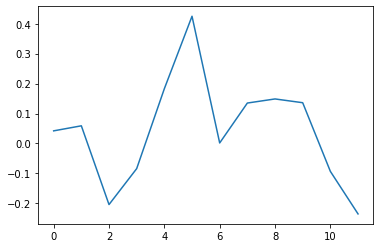

In [52]:
import matplotlib.pyplot as plt
plt.plot(yaxis)

In [24]:
models = [];
year = 2019
for i in range(1, 14):
    if i == 13: year += 1 # Account for Jan 2020 case
    data = getDataForWord2Vec(df[(df["month"] == i % 12) & (df["year"] == year)])
    if len(data):
        model = gensim.models.Word2Vec(data, min_count=1) 
        models.append({
            "month": i % 12,
            "year": year,
            "model": model
        })
    

In [30]:
for model in models: 
    print(str(model["month"]) + "/" + str(model["year"]))
    print(model["model"].most_similar(positive=["chinese"]))
    if("gross" in model["model"].wv): 
        print(model["model"].similarity("chinese", "gross"))
    print()
#     print(str(model["month"]) + "/" + str(model["year"]) + ": " + str(model["model"].similarity("chinese", "dirty")))

1/2019
[('people', 0.9998934864997864), ('china', 0.9995563626289368), ('world', 0.9995144009590149), ('would', 0.9995002746582031), ('like', 0.9994922876358032), ('one', 0.9994511008262634), ('time', 0.999414324760437), ('even', 0.9993738532066345), ('also', 0.9993313550949097), ('country', 0.9993169903755188)]
0.43330446

2/2019
[('people', 0.9998196959495544), ('china', 0.9994246959686279), ('www', 0.9993564486503601), ('would', 0.9991850852966309), ('like', 0.999155580997467), ('even', 0.9991507530212402), ('know', 0.9990978837013245), ('us', 0.9990249872207642), ('country', 0.9990077018737793), ('white', 0.9989726543426514)]
0.67270505

3/2019
[('people', 0.9997056722640991), ('china', 0.9992757439613342), ('https', 0.9990580081939697), ('like', 0.9987616539001465), ('com', 0.9987494349479675), ('www', 0.9987013936042786), ('twitter', 0.9986764192581177), ('us', 0.9986580610275269), ('even', 0.998573899269104), ('one', 0.9985232353210449)]
0.03259159

4/2019
[('people', 0.99929463

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """


In [56]:
model.most_similar(positive=['chinese'], topn=100)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('quarantined', 0.9873600602149963),
 ('dozens', 0.9866129755973816),
 ('central', 0.9845096468925476),
 ('scientists', 0.9833424687385559),
 ('woman', 0.9813871383666992),
 ('behind', 0.9803215861320496),
 ('state', 0.9803016185760498),
 ('quarantines', 0.9800556898117065),
 ('retail', 0.9800424575805664),
 ('mysterious', 0.9793493747711182),
 ('pneumonia-like', 0.9789493083953857),
 ('unidentified', 0.9788590669631958),
 ('report', 0.9771192073822021),
 ('11m', 0.9717527031898499),
 ('dies', 0.9711296558380127),
 ('store', 0.9709696173667908),
 ('possible', 0.9696741104125977),
 ('new', 0.969482421875),
 ('bar', 0.9693507552146912),
 ('travel', 0.9691596031188965),
 ('tourist', 0.9691296219825745),
 ('likely', 0.9690911769866943),
 ('cut', 0.9687844514846802),
 ('evacuation', 0.9686446785926819),
 ('visitor', 0.96837317943573),
 ('investigating', 0.9679380655288696),
 ('mainland', 0.9675858616828918),
 ('lockdown', 0.9675307869911194),
 ('caused', 0.9674668312072754),
 ('claims', 0.

In [31]:
model.wv.syn0.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


(25679, 100)